## Training Notebook for Image MultiClassfication


In [1]:
import random
from glob import glob
from collections import OrderedDict
import os.path as osp
import os

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer

import albumentations as A
import audiomentations as AA
from resnest.torch import resnest50
from resnest.torch.resnet import ResNet, Bottleneck

import colorednoise as cn

from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import librosa
import torchaudio

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader
from audiomentations.core.transforms_interface import BaseTransform, BaseWaveformTransform

from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

D:\ProgramFiles\anaconda3\envs\pytorch\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
D:\ProgramFiles\anaconda3\envs\pytorch\lib\site-packages\torchaudio\backend\utils.py:64: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  'The interface of "soundfile" backend is planned to change in 0.8.0 to '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.cuda.empty_cache()

## Model

For this notebook we will be training a model that is based on a ResNeSt: Split Attention Networks. Paper here
https://arxiv.org/abs/2004.08955

In [3]:
import torchvision

In [4]:
densenet121 = torchvision.models.resnet18(pretrained=True)

In [5]:
densenet121.fc

Linear(in_features=512, out_features=1000, bias=True)

In [6]:
#Model Config
MODEL_CONFIGS = {
    "resnest50_fast_1s1x64d":
    {
        "num_classes": 264,
        "block": Bottleneck,
        "layers": [3, 4, 6, 3],
        "radix": 1,
        "groups": 1,
        "bottleneck_width": 64,
        "deep_stem": True,
        "stem_width": 32,
        "avg_down": True,
        "avd": True,
        "avd_first": True
    }
}


def get_model(pretrained=True, n_class=65):
    """We create a model based on a resnest50 model, and then load in pretrained weights for the model"""
    model = ResNet(**MODEL_CONFIGS["resnest50_fast_1s1x64d"])
    n_features = model.fc.in_features

    fn = 'models/resnest50_fast_1s1x64d_conf_1.pt'
    model.load_state_dict(torch.load(fn, map_location='cpu'))
    #we add a new fully connected layer that will be trained for the birs classes
    model.fc = nn.Linear(n_features, n_class)
    return model

## Using other models
If you wish to sue resnets or other archtectures for transfer learning, you need to load in the model and change the head of the model. This is easy to do. 

Torchvision and timm, come with a variety of models that can be used. https://github.com/rwightman/pytorch-image-models

I will show you how to using the above function

In [7]:
from torchvision import models
## resnet50
def get_model2(pretrained=True, n_class=65):
    """We create a model based on a resnet model, and then load in pretrained weights for the model"""
    model = models.resnet50(pretrained=pretrained)
    n_features = model.fc.in_features
    #we add a new fully connected layer that will be trained for the birs classes
    model.fc = nn.Linear(n_features, n_class)
    return model

In [8]:
from timm import models
## EfficientNetB0 noisy student
def get_model3(pretrained=True, n_class=65):
    """We create a model based on a resnet model, and then load in pretrained weights for the model"""
    model = models.tf_efficientnet_b0_ns(pretrained=pretrained, drop_path_rate=0.2)
    n_features = model.classifier.in_features
    #we add a new fully connected layer that will be trained for the birs classes
    model.classifier = nn.Linear(n_features, n_class)
    return model

In [9]:
model2 = get_model2(pretrained=True) #This might take a few minuetes to download

In [10]:
model3 = get_model3(pretrained=True)

## Audio Augmentation

For the purpose of this notebook, I will be using GaussianNoise, GaussianNoiseSNR, PinkNoise, And Volume Control

In [11]:
class PinkNoise(BaseWaveformTransform):
    """Add pink noise to the samples with random Signal to Noise Ratio (SNR)"""

    supports_multichannel = True

    def __init__(self, min_snr=0.5, max_snr=20.0, p=0.5):
        """
        :param min_SNR: Minimum signal-to-noise ratio
        :param max_SNR: Maximum signal-to-noise ratio
        :param p: The probability of applying this transform
        """
        super().__init__(p)
        self.min_snr = min_snr
        self.max_snr = max_snr


    def apply(self, y, sample_rate):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        pink_noise = cn.powerlaw_psd_gaussian(1, len(y))
        a_pink = np.sqrt(pink_noise ** 2).max()
        augmented = (y + pink_noise * 1 / a_pink * a_noise).astype(y.dtype)
        return augmented
    
class VolumeControl(BaseWaveformTransform):
    """Control the volume of the sample to using various modes such as cosine or sine curves"""

    supports_multichannel = True

    def __init__(self,p=0.5, db_limit=10, mode="uniform"):
        """
        :param db_limit: Maximum db to apply to signal
        :param p: The probability of applying this transform
        """
        super().__init__(p)
        assert mode in ["uniform", "fade", "fade", "cosine", "sine"], \
            "`mode` must be one of 'uniform', 'fade', 'cosine', 'sine'"

        self.db_limit = db_limit
        self.mode = mode


    def apply(self, y: np.ndarray, sample_rate):
        db = np.random.uniform(-self.db_limit, self.db_limit)
        if self.mode == "uniform":
            db_translated = 10 ** (db / 20)
        elif self.mode == "fade":
            lin = np.arange(len(y))[::-1] / (len(y) - 1)
            db_translated = 10 ** (db * lin / 20)
        elif self.mode == "cosine":
            cosine = np.cos(np.arange(len(y)) / len(y) * np.pi * 2)
            db_translated = 10 ** (db * cosine / 20)
        else:
            sine = np.sin(np.arange(len(y)) / len(y) * np.pi * 2)
            db_translated = 10 ** (db * sine / 20)
        augmented = y * db_translated
        return augmented

class OneOf(BaseWaveformTransform):
    """ This is a class that will choose to do either one augmnetation or another from a list of augmentations
        Helpful when say using two types of noises like pink noise or white noise
    """
    def __init__(self, transforms: list, p=0.5):
        """
        :param transforms: list of transforms
        :param p: probability of applying this transform
        """
        super().__init__(p)
        self.transforms = transforms

    def __call__(self, y: np.ndarray, sample_rate):
        n_trns = len(self.transforms)
        trns_idx = np.random.choice(n_trns)
        trns = self.transforms[trns_idx]
        return trns(y, sample_rate)

## Image Transformations
The end model will require an input of a 3 channel spectrogram. Thuse we need functions to convert them to 3 channels, but also normalise the images

In [12]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """We take an input, convert it to three channels and normalise the image"""
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()
    #if the max -min is near zero, we clip the image and convert it so the values are between 0 and 255
    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def normalize(image, mean=None, std=None):
    """This function normalises an image"""
    image = image / 255.0
    if mean is not None and std is not None:
        image = (image - mean) / std
    return image.astype(np.float32)

## Cropping and Padding the audio signal
We need to crop and pad audio signals, so that the network always receives the same sized image/audio clip into the model for training.
If not it will throw an error. 

In [13]:
def crop_and_pad(fn, labels, period,total_duration, record):
    #we get the record make sure it is of len 1, 
    df = record.squeeze()
    np.put(labels, df.species_id, 1)
    
    t0 = max(df['X_min'], 0) # get the start time of the call and make sure it is not a negative number
    t1 = max(df['X_max'], 0) # get the end of the birdcall and make sure it is not zero
    t0 = np.random.uniform(t0, t1) #we choose a random point within the call
    t0 = max(t0, 0)
    t0 = min(t0, total_duration-period) #make sure it does not exceed the length of the call duration
    t1 = t0 + period #add the duration to get an end point
    
    df = record[(record.X_min < t1) & (record.X_max > t0)] #we get all records that are within the beginning and the end of the call
    if len(df):
        np.put(labels, df.species_id.unique(), 1) #if there are other bird calls between this time, we add a one to the label vector

    y, sr = librosa.load(fn, sr=None, offset=t0, duration=period) #we load the audio file
    
    return y, sr, labels, t0,t1
    

## Dataset 

This is the class that will prepare the data before it is passed onto the model. This is where we pas the CSV file and other argumnets on how we wish for the audio file to be adjusted.

This dataset will use audio files from xenocanto, which can be downloaded from https://www.kaggle.com/c/birdsong-recognition/discussion/164197

In [14]:
class TrainDataset:
    def __init__(self, tp,fp=None, fp_root=None, config=None,audio_transforms= None, image_transforms=None, mode='train', inv_counts=None):
        self.tp = tp #The Dataframe that contains the all the information we need for training etc. 
        self.fp =fp #This is a CSV  of false positive sounds like insects or mammals
        self.fp_root = fp_root       
        self.inv_counts = inv_counts #these are weights for a weighted sampler, so the distribution of chosen samples are weighted more classes that have fewer samples
        self.config = config
        self.data_root = self.config.TRAIN_AUDIO_ROOT
        self.nmels = self.config.nmels
        self.sr = self.config.sr
        self.original_sr = self.config.original_sr
        self.fmin, self.fmax = 0, self.config.f_max#the min and max frquency ranges the Melspectrogram will contain
        self.mode = mode #this sets the mode of the dataset, is it training, validating or testing
        self.num_classes = self.config.num_classes #number of classes that the model will be trained on 
        self.resampler = torchaudio.transforms.Resample(orig_freq=self.config.original_sr, new_freq=self.config.sr) #We will resample the audio from 44100 to a new sample rate

        self.audio_transforms= audio_transforms
        self.image_transforms= image_transforms

    def __len__(self):
        return self.tp.filepath.nunique() #The number of elements in the dataset, we are going for the number of audio files
    

    def __getitem__(self, idx): 
        #This is the function that loads the audio file, transforms it and 
        #returns the audio file and label back
        
        labels = np.zeros((self.num_classes,), dtype=np.float32) #We create the label vector
        filepath = self.tp.loc[idx, 'filepath'] # get filepath of the audiofile at the index within the CSV file
        df = self.tp.loc[self.tp.filepath == filepath] #we get all of the records associated with the filepath
        
        maybe_labels = df.species_id.unique() #place all possible species that appear within this clip as 0.2
        np.put(labels, maybe_labels, 0.2)
        
        df = df.sample(weights=df.species_id.apply(
            lambda x: self.inv_counts[x])) #we get a weighted sample of the records based on the weights
        fn = osp.join(self.data_root, filepath)
        y,sr, labels, t0, t1 = crop_and_pad(fn,labels, self.config.duration, self.config.total_duration, df) #we get the audio signal, and labels
        if self.fp is not None: #if we have false positives to add
            if random.random()<0.5:
                record =df[(df.X_min < t1) & (df.X_max > t0)] #we get a random point to inser a false positive
                end_idx = int((record.X_max.max() - t0)*self.sr)
                rem_len = max(0, len(y) - end_idx)
                idx = np.random.randint(0, len(self.fp))
                #we are using a xenocanto dataset from kaggle, so this line may need to be adjusted to account for your own false positive
                fn = osp.join(self.fp_root, self.fp.ebird_code[idx],self.fp.filename[idx])
                fn = fn.replace('mp3', 'wav') 
                y_other, _ = librosa.load(fn, sr=self.sr, #we load the call and add it to the y signal
                                        duration=None, mono=True,
                                        res_type='kaiser_fast')
                aug_len = min(len(y_other), rem_len)
                y[end_idx:end_idx+aug_len] = y_other[:aug_len]
#         y = self.resampler(torch.from_numpy(y).float()).numpy() #we resampled the audio signal
        # do augmentation
        y = self.audio_transforms(y, sample_rate = self.original_sr)
        if random.random() < 0.25: #we can also add clicks to the signal 
            tempo, beats = librosa.beat.beat_track(y=y, sr=self.original_sr)
            y = librosa.clicks(frames=beats, sr=self.sr, length=len(y))
        #we convert the audio signal to a melspec, convert to an image, and change the axis so it can be used as a tensor with pytorch
        melspec = librosa.feature.melspectrogram(
            y, sr=self.sr, n_mels=self.nmels, fmin=self.fmin, fmax=self.fmax,
        )

        melspec = librosa.power_to_db(melspec)
        melspec = mono_to_color(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        melspec = self.image_transforms(image=melspec)['image']
        melspec = np.moveaxis(melspec, 2, 0)
        
        return melspec, labels

In [15]:
class Dataset:
    def __init__(self, tp,config=None, mode='valid'):
        self.tp = tp #The Dataframe that contains the all the information we need for training etc.      
        self.config = config
        self.data_root = self.config.data_root
        
        self.nmels = self.config.nmels
        self.fmin, self.fmax = 0, self.config.f_max#the min and max frquency ranges the Melspectrogram will contain
        self.mode = mode #this sets the mode of the dataset, is it training, validating or testing
        self.num_classes = self.config.num_classes #number of classes that the model will be trained on 
        self.resampler = torchaudio.transforms.Resample(orig_freq=self.config.original_sr, new_freq=self.config.sr) #We will resample the audio from 44100 to a new sample rate

    def __len__(self):
        return self.tp.filepath.nunique() #The number of elements in the dataset, we are going for the number of audio files
    
    def __getitem__(self, idx): 
        #This is the function that loads the audio file, transforms it and 
        #returns the audio file and label back
        filepath = self.tp.loc[idx, 'filepath'] # get filepath at the index within the CSV file
        df = self.tp.loc[self.tp.filepath == filepath] #we get all of the records associated with the filepath
        audio_fn = osp.join(self.data_root, filepath)
        y, sr = librosa.load(audio_fn,sr=None, duration = self.config.total_duration)
        #For evaluation and testing, we predice across the whole audio file
        segments = len(y) / (self.config.stride*self.config.original_sr)
        segments = int(np.ceil(segments))
        
        melspecs_stacked = []
        length = int(self.config.duration * sr)
        #As in the training set, we get a length of the signal
        #resample it anbd then convert it to a melspectrogram
        #but here we are doing it for the whole duration of the audio file
        y_stacked = []
        for i in range(0,segments):
            if (i + 1) * length > len(y):
                y_ = y[len(y) - length:len(y)]
            else:
                y_ = y[i * length:(i + 1) * length]
            y_stacked.append(y_)
        
        melspec_stacked = []
        for y in y_stacked:
#             y = self.resampler(torch.from_numpy(y).float()).numpy()
            melspec = librosa.feature.melspectrogram(
                y, sr=self.config.original_sr, n_mels=self.nmels, fmin=self.fmin, fmax=self.fmax,
            )
            melspec = librosa.power_to_db(melspec)
            melspec = mono_to_color(melspec)
            melspec = normalize(melspec, mean=None, std=None)
            melspec = np.moveaxis(melspec, 2, 0)
            melspec_stacked.append(melspec)

        melspec_stacked = np.stack(melspec_stacked)
#             np.save(fn, melspec_stacked)
        if self.mode == 'valid':
            species = df.loc[:, 'species_id'].unique()
            species=species[species !=-1]
            labels = np.zeros((self.num_classes,))
            np.put(labels, species, 1)

            return melspec_stacked, labels
        else:
            return melspec_stacked

## Augmentations
These are the augmentations we will be using for the dataloader

In [16]:
audio_transforms = AA.Compose([
            OneOf([
                AA.AddGaussianSNR( p=0.5),
                PinkNoise( p=0.5)
            ], p=1.),
            AA.AddBackgroundNoise(sounds_path='../Background rain', p=0.5),   #if you want to add background rainnoise
            VolumeControl(p=0.5)
        ])

In [17]:
img_transform = A.Compose([
        A.OneOf([
            A.Cutout(max_h_size=5, max_w_size=20),
            A.CoarseDropout(max_holes=10),
            A.RandomBrightness(p=0.25),
        ], p=0.5)])

add for adding rain 


## Audio Augmentations

In [18]:
df = pd.read_csv('train_folds.csv')
y,sr = librosa.load(f'../{df.iloc[0].filepath}', sr=None)
Audio(y,rate =sr)

In [19]:
resampler = torchaudio.transforms.Resample(orig_freq=44000, new_freq=26000)

In [20]:
audio = resampler(torch.from_numpy(y).float()).numpy()
audio = audio_transforms(y, sample_rate=sr)
tempo, beats = librosa.beat.beat_track(y=audio, sr=32000)
Audio(audio,rate =sr)

# Image Augmentations

In [21]:
melspec = librosa.feature.melspectrogram(
            audio, sr=32000, n_mels=512, fmin=0, fmax=13000,
        )
melspec = librosa.power_to_db(melspec)
melspec = mono_to_color(melspec)
melspec = normalize(melspec, mean=None, std=None)
melspec = img_transform(image=melspec)['image']

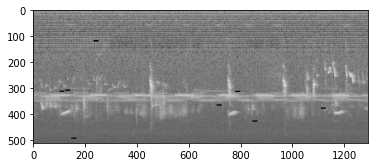

In [22]:
import matplotlib.pyplot as plt
plt.imshow(melspec)

## Metric
The metric used to evaluate network is the label-weighted label-ranking average precision, which is a generalization of the mean reciprocal rank measure for the case where there can be multiple true labels per audio file.

More information can be found here https://scikit-learn.org/stable/modules/model_evaluation.html#label-ranking-average-precision

In [23]:
def LWLRAP(preds, labels):
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes).to(preds.device)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(
        ground_truth_ranks, dim=-1, descending=False)
    # Number of GT labels per instance
    num_labels = labels.sum(-1)
    pos_matrix = torch.tensor(
        np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0).to(preds.device)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = scores.sum() / labels.sum()
    return score.item()

In [24]:
#If we wish to add in false positive noise 
fp = None#pd.read_csv('cornell-train.csv')
fp_root = None#'../../xenocanto/'

## Base Learner

We are using Pytorch Lightning to train the deep learning model. 
So we need to create a base learner that will load the data loaders, 
and specifies the schedulers,loss functions 

In [25]:
class BaseLearner(LightningModule):
    def __init__(self, config, train_recid, val_recid):
        super().__init__()
        self.config = config #our config file
        self.batch_size = self.config.batch_size #batchsize (number of images on the GPU)
        self.num_workers = self.config.num_workers #number of cpu threads to use when training, for windows we set this to 0. 
        self.lr = self.config.lr #the learning rate of the model, one of the most important hyper parameters
        self.epochs = self.config.epochs #number of epochs, the network will train on. 

        self.weight_decay = self.config.weight_decay #weight decay, which is used in the optimiser. 
        # To overcome catastrophic forgetting in the neural network, 
        #we can set positive weights in the loss function
        #more information can be found here https://arxiv.org/pdf/1612.00796.pdf
        pos_weight = torch.ones((config.num_classes,))
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight) # los function, we are using Binary Cross Entropy
        self.sr = self.config.sr
        self.train_recid = train_recid #ids of the filepath we wish to use for training
        self.val_recid = val_recid #ids of the filepath we wish to use for validation
        
    def train_dataloader(self):
        tp = train_tp[train_tp.filepath.isin(
            self.train_recid)].reset_index(drop=True) #We create a CSV file with all of the training ids
        self.train_recid = tp.filepath.unique() 

        inv_counts = dict(1/tp.species_id.value_counts()) #get weights for the representation of species within the csv file
        weights = tp.species_id.apply(lambda x: inv_counts[x])

        train_dataset = TrainDataset(tp,fp=fp, fp_root=fp_root, config=self.config, inv_counts=inv_counts,image_transforms = img_transform, audio_transforms = audio_transforms) # we create our dataset
        # we create our dataloader with a weighted sampler, which will sample under represented classes more
        train_sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset),replacement=True)# we create our dataset
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size,
                                  num_workers=self.num_workers,
                                  sampler=train_sampler,
                                  drop_last=True,
                                  pin_memory=True)
        return train_loader

    def val_dataloader(self):
        val_tp = train_tp[train_tp.filepath.isin( #We create a CSV file with all of the validation ids
            self.val_recid)].reset_index(drop=True)
        val_recid = val_tp.filepath.unique()
        overlap = set(val_recid).intersection(set(self.train_recid))
        
        val_tp = val_tp[~val_tp.filepath.isin(overlap)] #We make sure there is no overlap between the training and validation sets 
        #we then create the validation dataloader and dataset
        val_dataset = Dataset(val_tp,config=self.config,mode='valid')
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, num_workers=self.num_workers,shuffle=False,
                                pin_memory=True)
        return val_loader

    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(), lr=self.config.lr, # we are using the AdamW optimiser for training 
                                  weight_decay=self.config.weight_decay) #information can be found here https://www.iprally.com/news/recent-improvements-to-the-adam-optimizer
        # We create a shceduler that will change the learning rate and other parameters 
        # this will change the learning rate when the validation loss value does not improve after 2 epochs
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                                    mode='min',
                                                                    factor=0.5,
                                                                    patience=2,
                                                                    verbose=True),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1,
            'strict': True,
        }

        self.optimizer = optim
        self.scheduler = scheduler

        return [optim], [scheduler]

## Learner

This learner will deal with all of the training and validation loop, so we do not need to write out a training loop or logging functions. Pytorch Lightning provides this already

In [26]:
class Learner(BaseLearner):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.model = get_model(
            pretrained=True, n_class=self.config.num_classes) # we create our model

    def forward(self, x):
        return self.model(x) # this is the function that passes the input tensor to the model

    def training_step(self, batch, batch_idx):
        x, y = batch #We get our images, and labels
        preds = self(x) #we predict on the images
        loss = self.loss_fn(preds, y) #calculate the loss
        with torch.no_grad(): #with no gradient we calculate the metric for how well the model is doing
            lwlrap = LWLRAP(preds, y)
        metrics = {"train_loss": loss.item(), "train_lwlrap": lwlrap} #we log the metrics and return the loss
        self.log_dict(metrics,
                      on_epoch=True, on_step=True)

        return loss

    @torch.no_grad() 
    def validation_step(self, batch, batch_idx):
        x, y = batch #we predict over the images that are within x, keeping the max predictions from output from the model
        for i, x_partial in enumerate(torch.split(x, 1, dim=1)):
            x_partial = x_partial.squeeze(1)
            if i == 0:
                preds = self(x_partial)
            else:
                # take max over predictions
                preds = torch.max(preds, self(x_partial))
        val_loss = self.loss_fn(preds, y).item() #we calculate the loss and metrics
        val_lwlrap = LWLRAP(preds, y)
        # loss is tensor. The Checkpoint Callback is monitoring 'checkpoint_on' 
        #we log the validation score and loss val
        metrics = {"val_loss": val_loss, "val_lwlrap": val_lwlrap}
        self.log_dict(metrics, prog_bar=True,
                      on_epoch=True, on_step=True)

# Training 

We are about to train the model, we have all of the components but now need to put it all together. 

In [28]:
train_tp = pd.read_csv('train_folds.csv')# we load the training CSV

fold_df = train_tp.drop_duplicates('filepath')# We create a CSV ffile that has unique filepath, so we do not validate on audio files that are being used in training

# train_tp = train_tp[train_tp['t_diff'] >=0.03]#we filter any calls that are less than a set value
len(train_tp)

1746

In [29]:
train_tp.t_diff.min(),train_tp.t_diff.max(),train_tp.t_diff.mean()

(0.1213460000000008, 14.922179, 1.6118591483390605)

In [30]:
train_tp.species_id.nunique()

37

In [33]:
class Config:
    batch_size = 8 #batchsize
    weight_decay = 1e-8 #weight decay
    lr = 1e-3 #learning rate
    num_workers = 0#4 #number of threads to use  WINDOWS: Use 0 num_workers
    epochs = 5 #number of epochs I normally suggest around 50 epochs
    num_classes = train_tp.species_id.nunique() #
    sr = 32_000 #the frequency to resample the audio file
    duration = 3. #the sound window to train on , 
    total_duration = 15.0  #This duratation can be changed
    nmels = 128 #nwels by changing this beware of memory issues that might arise on the GPU
    ROOT = '.'
    TRAIN_AUDIO_ROOT = osp.join(ROOT, "..") #train audio directory #this can be changed for other directories
    data_root = osp.join(ROOT, "..")# validation validation audio directory
    exp_name = 'test' #name of the experiment
    save_path = 'weights' #file path where the models are saved
    loss_fn = torch.nn.BCEWithLogitsLoss() #loss function 
    f_max = 13000 #this is the maximum frequency that will be shown in the melspectrogram. 
    original_sr = 44100 #This is the original sample rate (Pytorch Audio has an issue with 44100 resampling and goes really slowly)
    stride = 3. #this is the sliding window time, it can be changed to be higher or lower
    
config = Config()

In [34]:
num_folds = len(fold_df.kfold.unique()) # get number of folds in the csv

for fold in range(num_folds):
    print('\n\nTraining fold', fold)
    print('*' * 40)

    train_recid = fold_df[fold_df.kfold != fold].filepath #get our ids for training and validation
    val_recid = fold_df[fold_df.kfold == fold].filepath
    
    learner = Learner(config=config, train_recid=train_recid,
                   val_recid=val_recid)
    #we save check points saving only the top 5 models 
    checkpoint_callback = ModelCheckpoint(
        dirpath = f'{config.save_path}/{config.exp_name}/{fold}',
        monitor='val_lwlrap_epoch',
        filename='{epoch:02d}-{val_lwlrap_epoch:.3}',
        mode='max',
        save_top_k=5,
        save_weights_only=True,
    )
    #we stop the model early if the metrics doesnt't improve after 5 epochs
    early_stopping = EarlyStopping(monitor='val_lwlrap_epoch', mode='max', patience=5,
                                   verbose=True)
    #create a trainer
    trainer = Trainer(gpus=1,
                      max_epochs=config.epochs,
                      progress_bar_refresh_rate=1,                      
                      accumulate_grad_batches=4,
                      num_sanity_val_steps=0,
                      callbacks=[checkpoint_callback, early_stopping])

    trainer.fit(learner)



Training fold 0
****************************************


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | model   | ResNet            | 24.2 M
----------------------------------------------
24.2 M    Trainable params
0         Non-trainable params
24.2 M    Total params


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch     5: reducing learning rate of group 0 to 5.0000e-04.


Training fold 1
****************************************


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | model   | ResNet            | 24.2 M
----------------------------------------------
24.2 M    Trainable params
0         Non-trainable params
24.2 M    Total params


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]



Training fold 2
****************************************


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | model   | ResNet            | 24.2 M
----------------------------------------------
24.2 M    Trainable params
0         Non-trainable params
24.2 M    Total params


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]



Training fold 3
****************************************


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | model   | ResNet            | 24.2 M
----------------------------------------------
24.2 M    Trainable params
0         Non-trainable params
24.2 M    Total params


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]



Training fold 4
****************************************


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | loss_fn | BCEWithLogitsLoss | 0     
1 | model   | ResNet            | 24.2 M
----------------------------------------------
24.2 M    Trainable params
0         Non-trainable params
24.2 M    Total params


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Cross Validation of Training Data

In [35]:
classes = list(np.loadtxt('classes.txt',dtype=str, delimiter='\n'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
species_cols = [f'{classes[i]}' for i in range(len(classes))]

cv_preds = pd.DataFrame(columns=species_cols)
cv_preds['filepath'] = train_tp['filepath'].drop_duplicates()
cv_preds.loc[:, species_cols] = 0
cv_preds = cv_preds.reset_index(drop=True)

label_df = cv_preds.copy()


In [36]:
def average_model(paths):
    """This function loads the weights that are stored within a path and then averages the weights across the models"""
    weights = np.ones((len(paths),))
    weights = weights/weights.sum()
    for i, p in enumerate(paths):
        m = torch.load(p,map_location='cpu')['state_dict']
        if i == 0:
            averaged_w = OrderedDict()
            for k in m.keys():
                if 'pos' in k: continue
                # remove pl prefix in state dict
                knew = k.replace('model.', '')
                averaged_w[knew] = weights[i]*m[k]
        else:
            for k in m.keys():
                if 'pos' in k: continue
                knew = k.replace('model.', '')
                averaged_w[knew] = averaged_w[knew] + weights[i]*m[k]
    return averaged_w

We save the models from the conig.save_path and experiment name

In [37]:
config.save_path, config.exp_name

('weights', 'test')

In [38]:
classes

['BarCucDov',
 'BroThrBar1',
 'BroThrBar3',
 'CheBelPar',
 'CreCheBab1',
 'EyeWreBab1',
 'FlaFroBar1',
 'GreHeaCan',
 'HorWreBab1',
 'HorWreBab3',
 'JavCoc1',
 'JavFul1',
 'JavHel2',
 'JavLau1',
 'JavTes1',
 'JavTes3',
 'LesSho',
 'LitPieFly1',
 'LitPieFly2',
 'LitPieFly3',
 'LitSpi2',
 'MouLea',
 'MouLeaWar1',
 'MouLeaWar2',
 'PieShrVir',
 'PygCup1',
 'PygCup2',
 'PygCup3',
 'SnoBroFly1',
 'SnoBroFly2',
 'SunBruCuc1',
 'SunBruCuc2',
 'SunBusWar',
 'SunCuc1',
 'SunCucShr1',
 'SunWar',
 'TriShrVir1']

In [39]:
model = get_model(pretrained=False, n_class = len(classes)) #we create a model
model.to(device)

for fold in range(5): #change to include an array 

    paths = glob(f"{config.save_path}/{config.exp_name}/{fold}/*.ckpt") #load a pretrained model we trained
    averaged_w = average_model(paths) # we average the weights
    model.load_state_dict(averaged_w) #we load the weights
    model.eval() #put the model into evaluation model
    
    val_recid = fold_df[fold_df.kfold == fold].filepath #get our validation ids
    val_tp = train_tp[train_tp.filepath.isin(val_recid)].reset_index(drop=True)
    dataset = Dataset(val_tp, config=config, mode='valid')
    
    test_loader = DataLoader(dataset, batch_size=config.batch_size,
                             num_workers=config.num_workers,
                             shuffle=False, drop_last=False)
    tk = tqdm(test_loader, total=len(test_loader))
    sub_index = 0
    with torch.no_grad():
        for i, (im,l) in enumerate(tk):
            _preds, labels = [], []
            im = im.to(device)
            for i, x_partial in enumerate(torch.split(im, 1, dim=1)):
                x_partial = x_partial.squeeze(1)
                if i == 0:
                    preds = model(x_partial)
                else:
                    # take max over predictions
                    preds = torch.max(preds, model(x_partial))

            o = preds.sigmoid().cpu().numpy()
            _preds.extend(o)
            labels.extend(l.cpu().numpy())
            for val, ll in zip(o,l.cpu().numpy()): #we add the predictions to a predictions csv file
                cv_preds.loc[sub_index, species_cols] += list(val)
                label_df.loc[sub_index, species_cols] = ll
                sub_index += 1
            
    p = torch.from_numpy(np.array(_preds)) 
    t = torch.from_numpy(np.array(labels))
    print(f"Fold {fold} lwlrap: {LWLRAP(p, t):.6}")
    
cv_preds.loc[:, species_cols] /=5

preds = cv_preds.loc[:,species_cols].values.astype(np.float32)
preds = torch.from_numpy(preds)

labels = label_df.loc[:,species_cols].values.astype(np.float32)
labels = torch.from_numpy(labels)

print(f"Final Ensemble lwlrap: {LWLRAP(preds, labels):.6}")

  0%|          | 0/17 [00:00<?, ?it/s]

Fold 0 lwlrap: 0.329318


  0%|          | 0/17 [00:00<?, ?it/s]

Fold 1 lwlrap: 0.198285


  0%|          | 0/17 [00:00<?, ?it/s]

Fold 2 lwlrap: 0.274402


  0%|          | 0/17 [00:00<?, ?it/s]

Fold 3 lwlrap: 0.224662


  0%|          | 0/17 [00:00<?, ?it/s]

Fold 4 lwlrap: 0.392193
Final Ensemble lwlrap: 0.248303


#### This is the recall and precision for the combined ensemble, but can be changed 

In [40]:
n_classes =config.num_classes
from sklearn.metrics import precision_score, f1_score, recall_score
thresh = 0.1

for i in range(n_classes):
    p = preds[:,i]
    p = [0 if pp < thresh else 1 for pp in p]
    print(f'{classes[i]} Precision: {precision_score(labels[:, i], p)}, Recall: {recall_score(labels[:, i], p)}, F1-Score: {f1_score(labels[:, i], p)}')  

BarCucDov Precision: 0.0, Recall: 0.0, F1-Score: 0.0
BroThrBar1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
BroThrBar3 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
CheBelPar Precision: 0.0, Recall: 0.0, F1-Score: 0.0
CreCheBab1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
EyeWreBab1 Precision: 0.3333333333333333, Recall: 0.02857142857142857, F1-Score: 0.05263157894736842
FlaFroBar1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
GreHeaCan Precision: 0.0, Recall: 0.0, F1-Score: 0.0
HorWreBab1 Precision: 0.25, Recall: 0.041666666666666664, F1-Score: 0.07142857142857142
HorWreBab3 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
JavCoc1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
JavFul1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
JavHel2 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
JavLau1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
JavTes1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
JavTes3 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
LesSho Precision: 0.0, Recall: 0.0, F1-Score: 0.0
LitPieFly1 Precision: 0.0,

## Saving a model for inference

To save a model out that we use for evaluation or inference we get the average of the models weights and save out their final weights for each fold

In [41]:
save_path = f'{config.save_path}/{config.exp_name}/models/' #The file path, you can change this to what ever you like
os.makedirs(save_path, exist_ok=True) #we create the folder
model_name = 'model_'
model = get_model(pretrained=True, n_class=config.num_classes)
for i in range(num_folds): #we go through the number of folds 
    paths = glob(f"{config.save_path}/{config.exp_name}/{fold}/*.ckpt") #load a pretrained model we trained
    averaged_w = average_model(paths) # we average the weights
    model.load_state_dict(averaged_w) #we load the weights
    torch.save(model.state_dict(),f'{save_path}/{model_name}{i}.pth') #we save the model out 

## Loading models
to load a model for use, its quite simple. We create a model with the base model and load our weights.
I am choosing the model from the 3rd fold

In [42]:
load_path = f'{config.save_path}/{config.exp_name}/models/model_3.pth'
model = get_model(pretrained=True, n_class=config.num_classes)
model.load_state_dict(torch.load(load_path,map_location='cpu'))

<All keys matched successfully>

# Evaluation 

We Have now trained models, so we can now evaluate them on a testset. 

In [48]:
#we load our test set and create a CSV file that can accept the predictions and labels
classes = list(np.loadtxt('classes.txt',dtype=str, delimiter='\n'))
test = pd.read_csv('../labels_test_CD_20210309.csv')
test['filepath'] = [f'Test_data_CD/{f}' for f in test.wave]
test['species_id'] = [classes.index(s) if s in classes else -1 for s in test.Label]

species_cols = [f'{classes[i]}' for i in range(len(classes))]

cv_preds = pd.DataFrame(columns=species_cols)
cv_preds['filepath'] = test['filepath'].drop_duplicates()
cv_preds.loc[:, species_cols] = 0
cv_preds = cv_preds.reset_index(drop=True)

label_df = cv_preds.copy()
test = test.reset_index(drop=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
cv_preds.head()

,BarCucDov,BroThrBar1,BroThrBar3,CheBelPar,CreCheBab1,EyeWreBab1,FlaFroBar1,GreHeaCan,HorWreBab1,HorWreBab3,...,SnoBroFly1,SnoBroFly2,SunBruCuc1,SunBruCuc2,SunBusWar,SunCuc1,SunCucShr1,SunWar,TriShrVir1,filepath
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test_data_CD/extr_1670_B09_20190727_060000_All...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test_data_CD/extr_1676_B01_20190718_060000_All...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test_data_CD/extr_1463_B05_20181212_000009_All...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test_data_CD/extr_1673_B05_20190729_060000_All...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test_data_CD/extr_2153_B04_20190226_000231_All...


In [50]:
config.data_root = '..'

## Evaluation Loop

In [51]:
model = get_model(pretrained=False, n_class = len(classes)) #we create a model
model.to(device)

for fold in range(5): #change to include an array 

    paths = glob(f"{config.save_path}/{config.exp_name}/{fold}/*.ckpt")  #load a pretrained model we trained
    averaged_w = average_model(paths) # we average the weights
    model.load_state_dict(averaged_w) #we load the weights
    model.eval() #put the model into evaluation model
    dataset = Dataset(test, config=config, mode='valid')
    
    test_loader = DataLoader(dataset, batch_size=config.batch_size,
                             num_workers=config.num_workers,
                             shuffle=False, drop_last=False)
    tk = tqdm(test_loader, total=len(test_loader))
    sub_index = 0
    with torch.no_grad():
        for i, (im,l) in enumerate(tk):
            _preds, labels = [], []

            im = im.to(device)
            for i, x_partial in enumerate(torch.split(im, 1, dim=1)):
                x_partial = x_partial.squeeze(1)
                if i == 0:
                    preds = model(x_partial)
                else:
                    # take max over predictions
                    preds = torch.max(preds, model(x_partial))

            o = preds.sigmoid().cpu().numpy()
            _preds.extend(o)
            labels.extend(l.cpu().numpy())
            for val, ll in zip(o,l.cpu().numpy()):
                cv_preds.loc[sub_index, species_cols] += list(val)
                label_df.loc[sub_index, species_cols] = ll
                sub_index += 1
            
    p = torch.from_numpy(np.array(_preds)) 
    t = torch.from_numpy(np.array(labels))
    print(f"lwlrap: {LWLRAP(p, t):.6}")
    
cv_preds.loc[:, species_cols] /=5

preds = cv_preds.loc[:,species_cols].values.astype(np.float32)
preds = torch.from_numpy(preds)

labels = label_df.loc[:,species_cols].values.astype(np.float32)
labels = torch.from_numpy(labels)

print(f"Final Ensemble lwlrap: {LWLRAP(preds, labels):.6}")

  0%|          | 0/20 [00:00<?, ?it/s]

lwlrap: 0.422685


  0%|          | 0/20 [00:00<?, ?it/s]

lwlrap: 0.563148


  0%|          | 0/20 [00:00<?, ?it/s]

lwlrap: 0.461785


  0%|          | 0/20 [00:00<?, ?it/s]

lwlrap: 0.750992


  0%|          | 0/20 [00:00<?, ?it/s]

lwlrap: 0.577546
Final Ensemble lwlrap: 0.349557


In [52]:
label_df.to_csv('labels.csv',index=False)
cv_preds.to_csv('preds.csv', index=False)

In [53]:
cv_preds = pd.read_csv('output.csv')
labels_df = pd.read_csv('labels.csv')

In [54]:
n_classes =config.num_classes
from sklearn.metrics import precision_score, f1_score, recall_score
thresh = 0.1
for i in range(n_classes):
    p = preds[:,i]
    p = [0 if pp < thresh else 1 for pp in p]
    print(f'{classes[i]} Precision: {precision_score(labels[:, i], p)}, Recall: {recall_score(labels[:, i], p)}, F1-Score: {f1_score(labels[:, i], p)}')  

BarCucDov Precision: 0.0, Recall: 0.0, F1-Score: 0.0
BroThrBar1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
BroThrBar3 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
CheBelPar Precision: 0.0, Recall: 0.0, F1-Score: 0.0
CreCheBab1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
EyeWreBab1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
FlaFroBar1 Precision: 1.0, Recall: 0.4, F1-Score: 0.5714285714285715
GreHeaCan Precision: 0.0, Recall: 0.0, F1-Score: 0.0
HorWreBab1 Precision: 1.0, Recall: 0.04477611940298507, F1-Score: 0.08571428571428572
HorWreBab3 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
JavCoc1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
JavFul1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
JavHel2 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
JavLau1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
JavTes1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
JavTes3 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
LesSho Precision: 0.0, Recall: 0.0, F1-Score: 0.0
LitPieFly1 Precision: 0.0, Recall: 0.0, F1-Score: 0.0
LitPie

### fin